In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt
import scipy.io
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
import seaborn as sns

import pandas as pd
import xlsxwriter
import numpy as np

tf.get_logger().setLevel('ERROR')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
loaded_model = tf.keras.models.load_model('models/96/96_1Dense_0.3Val_noDrop_recall_model-improvement-80-0.93')

intermediate_layer_model = tf.keras.Model(inputs=loaded_model.get_layer("text").input,
                                       outputs=loaded_model.get_layer("dense2").output)


intermediate_layer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [3]:
data = pd.read_csv(r'C:\Users\MOHSEN-ASUS\JupyterProjects\GPT-bert\AWAGPT.csv')

In [4]:
class_names = pd.read_csv(r'C:\Users\MOHSEN-ASUS\JupyterProjects\GPT-bert\bert_data_withoutClassWord.csv')
class_names['class'].unique()

array(['Antelope', 'grizzly+bear', 'killer+whale', 'beaver', 'dalmatian',
       'persian+cat', 'horse', 'german+shepherd', 'blue+whale',
       'siamese+cat', 'skunk', 'mole', 'tiger', 'hippopotamus', 'leopard',
       'moose', 'spider+monkey', 'humpback+whale', 'elephant', 'gorilla',
       'ox', 'fox', 'sheep', 'seal', 'chimpanzee', 'hamster', 'squirrel',
       'rhinoceros', 'rabbit', 'bat', 'giraffe', 'wolf', 'chihuahua',
       'rat', 'weasel', 'otter', 'buffalo', 'zebra', 'giant+panda',
       'deer', 'bobcat', 'pig', 'lion', 'mouse', 'polar+bear', 'collie',
       'Walrus', 'raccoon', 'cow', 'dolphin'], dtype=object)

In [5]:
embbeding_size = 96

In [6]:
data["class"].unique()

array(['Antelope', 'beaver', 'dalmatian', 'horse', 'skunk', 'mole',
       'tiger', 'hippopotamus', 'leopard', 'moose', 'elephant', 'gorilla',
       'ox', 'fox', 'sheep', 'seal', 'chimpanzee', 'hamster', 'squirrel',
       'rhinoceros', 'rabbit', 'bat', 'giraffe', 'wolf', 'chihuahua',
       'rat', 'weasel', 'otter', 'buffalo', 'zebra', 'deer', 'bobcat',
       'pig', 'lion', 'mouse', 'collie', 'Walrus', 'raccoon', 'cow',
       'dolphin', 'grizzly+bear', 'killer+whale', 'persian+cat',
       'german+shepherd', 'blue+whale', 'siamese+cat', 'spider+monkey',
       'humpback+whale', 'giant+panda', 'polar+bear'], dtype=object)

In [7]:
def get_BERTembbedings(text, model):
    
    text = [text]
    text_tensor = tf.convert_to_tensor(text, dtype=tf.string)
    model_output = model(text_tensor)
    
    return model_output

In [8]:
def embbedings_labels_generator(dataset, selected_classes, BERT, embbeding_size=embbeding_size):
    
    # an array for labels
    labels = np.array([])
    
    # in the line below i am creating a zero array to append my embbedings to it (i dont know how to do it without creating a zero)
    class_texts_embbedings = np.zeros([1, embbeding_size])
    
    for i in selected_classes:
        
        # getting all of the texts belong to class i
        class_texts = dataset[dataset["class"] == i]
        class_texts = class_texts["text"]
        
        for j in class_texts:
            
            # obtaining embbedings of class i texts using "get_BERTembbedings" and appending them to an array
            class_texts_embbedings = np.append(class_texts_embbedings, get_BERTembbedings(j, BERT), axis=0)
            
            # putting labels in labels array
            labels = np.append(labels, i)  
            
        
    # deleting the zero array from the first row
    class_texts_embbedings = np.delete(class_texts_embbedings, 0, 0)
    
    return class_texts_embbedings, labels

In [9]:
class_name = ["Antelope"]

my_embbedings, my_labels = embbedings_labels_generator(data, class_name, intermediate_layer_model)

In [10]:
km = KMeans(n_clusters=3)
cluster_prediction = km.fit_predict(my_embbedings)
cluster_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0])

In [11]:
def att_generator(embbedings, num_clusters=3):
    
    #clustering embbedings
    km = KMeans(n_clusters=num_clusters)
    cluster_prediction = km.fit_predict(my_embbedings)
    
    #finding the dominant cluster
    counts = np.bincount(cluster_prediction)
    dominant_cluster = np.argmax(counts)
    
    #convert to dataframe for ease of use
    df = pd.DataFrame(embbedings)
    
    #include the cluster labels
    df["clusters"] = cluster_prediction
    
    #choosing the dominant cluster ebbedings & calculate the mean of them to produce the attribute
    dominant_embbedings = df[df["clusters"] == dominant_cluster]
    dominant_embbedings = dominant_embbedings.drop(["clusters"], axis=1)
    dominant_embbedings_nparray = dominant_embbedings.to_numpy()
    the_attribute = np.mean(dominant_embbedings_nparray, axis=0)
    
    return the_attribute

In [12]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [13]:
all_classes = class_names['class'].unique()
attribute_array = np.zeros([1, embbeding_size])

for i in all_classes:
    
    my_embbedings, my_labels = embbedings_labels_generator(data, [i], intermediate_layer_model)
    myatt = att_generator(my_embbedings)
    myatt = myatt.reshape(1, embbeding_size)
    
    attribute_array = np.append(attribute_array, myatt, axis=0)

attribute_array = np.delete(attribute_array, 0, 0)
attribute_array = attribute_array.transpose()

In [14]:
the_mat_file = scipy.io.loadmat('att_splits_AWA2.mat')
the_mat_file["att"] = attribute_array

print(the_mat_file["att"].shape)

(96, 50)


In [15]:
scipy.io.savemat('myatt_splits96_1Dense_0.3Val_noDrop_recall.mat', the_mat_file)

# normalizing atts (0, 1)

In [16]:
the_mat_file = scipy.io.loadmat('myatt_splits96_1Dense_0.3Val_noDrop_recall.mat')
the_mat_file["att"] = NormalizeData(the_mat_file["att"])

scipy.io.savemat('myatt_splits96norm_1Dense_0.3Val_noDrop_recall.mat', the_mat_file)

# normalizing atts (custom)

In [9]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# load data
the_mat_file = scipy.io.loadmat('myatt_splits96norm_1Dense_0.3Val_noDrop_AWA2.mat')
data = the_mat_file["att"]
# create scaler
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
# fit scaler on data
scaler.fit(data)
# apply transform
normalized = scaler.transform(data)
the_mat_file["att"] = normalized

scipy.io.savemat('myatt_splits96norm(-0.5, 0.5)_1Dense_0.3Val_noDrop_AWA2.mat', the_mat_file)

# Histogram

-0.0037535816785525078
0.35542511027525175


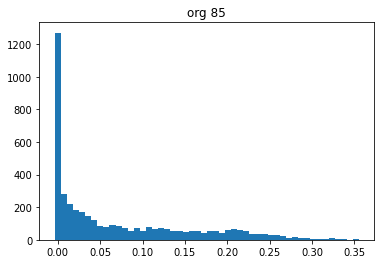

In [17]:
org_att = scipy.io.loadmat('att_splits_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("org 85")
plt.show()

0.0
1.0


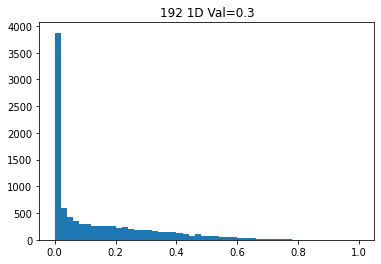

In [18]:
org_att = scipy.io.loadmat('myatt_splits192norm_1Dense_0.3Val_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("192 1D Val=0.3")
plt.show()

0.0
1.0


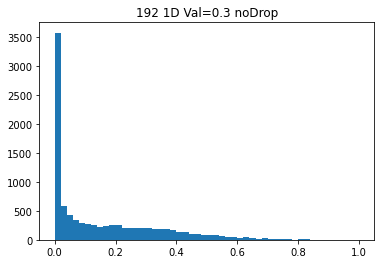

In [16]:
org_att = scipy.io.loadmat('myatt_splits192norm_1Dense_0.3Val_noDrop_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("192 1D Val=0.3 noDrop")
plt.show()

0.0
1.0


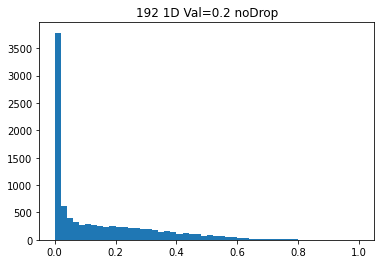

In [16]:
org_att = scipy.io.loadmat('myatt_splits192norm_1Dense_0.2Val_noDrop_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("192 1D Val=0.2 noDrop")
plt.show()

0.0
1.0


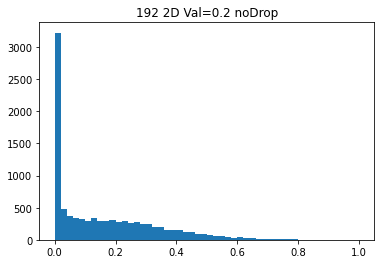

In [16]:
org_att = scipy.io.loadmat('myatt_splits192norm_2Dense_0.2Val_noDrop_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("192 2D Val=0.2 noDrop")
plt.show()

0.0
1.0


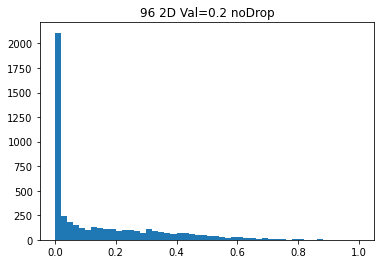

In [16]:
org_att = scipy.io.loadmat('myatt_splits96norm_2Dense_0.2Val_noDrop_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("96 2D Val=0.2 noDrop")
plt.show()

0.0
1.0


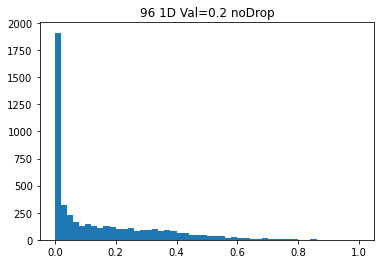

In [16]:
org_att = scipy.io.loadmat('myatt_splits96norm_1Dense_0.2Val_noDrop_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("96 1D Val=0.2 noDrop")
plt.show()

0.0
1.0


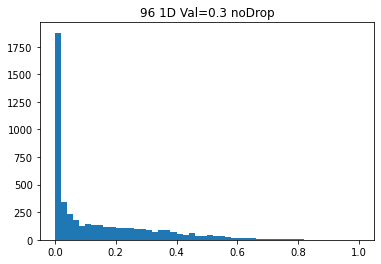

In [16]:
org_att = scipy.io.loadmat('myatt_splits96norm_1Dense_0.3Val_noDrop_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("96 1D Val=0.3 noDrop")
plt.show()

0.0
1.0


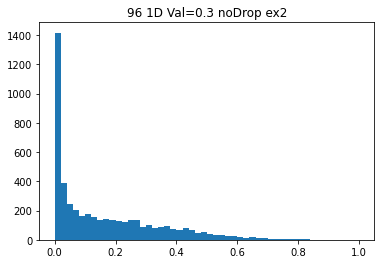

In [16]:
org_att = scipy.io.loadmat('myatt_splits96norm_1Dense_0.3Val_noDrop_ex2_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("96 1D Val=0.3 noDrop ex2")
plt.show()

0.0
1.0


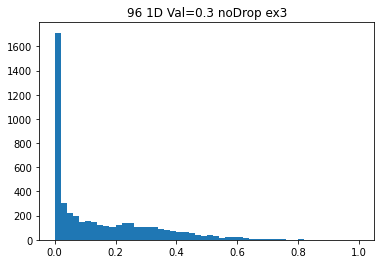

In [32]:
org_att = scipy.io.loadmat('myatt_splits96norm_1Dense_0.3Val_noDrop_ex3_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("96 1D Val=0.3 noDrop ex3")
plt.show()

0.0
1.0


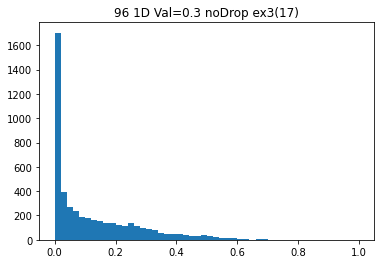

In [63]:
org_att = scipy.io.loadmat('myatt_splits96norm_1Dense_0.3Val_noDrop_ex3(11)_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("96 1D Val=0.3 noDrop ex3(17)")
plt.show()

0.0
1.0


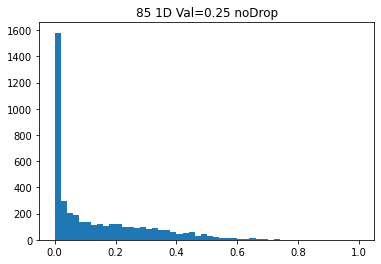

In [18]:
org_att = scipy.io.loadmat('myatt_splits85norm_1Dense_0.25Val_noDrop.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("85 1D Val=0.25 noDrop")
plt.show()

0.0
1.0


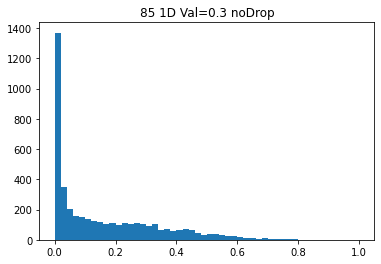

In [16]:
org_att = scipy.io.loadmat('myatt_splits85norm_1Dense_0.3Val_noDrop.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("85 1D Val=0.3 noDrop")
plt.show()

0.0
1.0


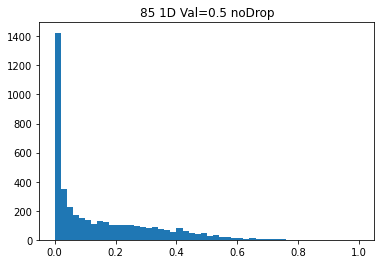

In [16]:
org_att = scipy.io.loadmat('myatt_splits85norm_1Dense_0.5Val_noDrop.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("85 1D Val=0.5 noDrop")
plt.show()

0.0
1.0


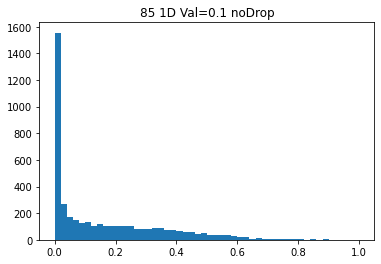

In [16]:
org_att = scipy.io.loadmat('myatt_splits85norm_1Dense_0.1Val_noDrop.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("85 1D Val=0.1 noDrop")
plt.show()

0.0
1.0


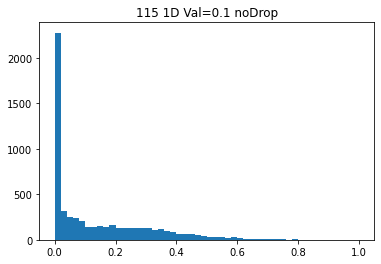

In [16]:
org_att = scipy.io.loadmat('myatt_splits115norm_1Dense_0.1Val_noDrop.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("115 1D Val=0.1 noDrop")
plt.show()

0.0
1.0


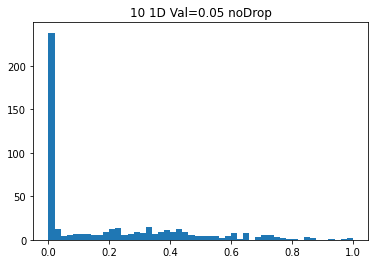

In [16]:
org_att = scipy.io.loadmat('myatt_splits10norm_1Dense_0.05Val_noDrop.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("10 1D Val=0.05 noDrop")
plt.show()

# normalizing altts (custom)

# Comparing myatt with orgatt on TSNE

In [15]:
def TSNE_ploting(x, y, file_png):
    
    class_count = len(np.unique(y))
    
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(x)
    
    df = pd.DataFrame()
    df["y"] = y
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", class_count),
                    data=df).set(title="mydata T-SNE projection")
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.legend(fontsize='5', title_fontsize='14')

    plt.savefig(file_png, dpi=300)
    plt.close()

In [16]:
the_mat_file = scipy.io.loadmat('att_splits_AWA1.mat')

print(the_mat_file["att"].shape)
print(attribute_array.shape)

(85, 50)
(192, 50)


In [20]:
attribute_array

array([[1.40729118, 0.        , 2.34951765, ..., 0.00874811, 0.97208293,
        2.23851849],
       [2.04070048, 1.24076981, 1.9815244 , ..., 3.50752952, 1.34396204,
        2.06051731],
       [0.05638115, 1.45450144, 0.        , ..., 1.04308674, 3.03288686,
        0.00797506],
       ...,
       [0.59692127, 0.        , 2.38340484, ..., 0.        , 0.        ,
        0.00513902],
       [0.12023851, 2.20131117, 1.49932921, ..., 0.50277754, 3.73165469,
        1.42954434],
       [0.29258359, 0.74250461, 0.        , ..., 0.41392834, 1.23477551,
        0.14461981]])

In [17]:
our_y = np.zeros(attribute_array.shape[1])
our_y.shape

(50,)

In [18]:
TSNE_ploting(attribute_array.transpose(), our_y, "myatt.png")

C:\Users\MOHSEN-ASUS\.conda\envs\piptext\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\MOHSEN-ASUS\.conda\envs\piptext\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 10.620804
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.278179
[t-SNE] KL divergence after 1000 iterations: 0.421785


In [38]:
TSNE_ploting(the_mat_file["att"].transpose(), our_y, "orgatt.png")

C:\Users\MOHSEN-ASUS\.conda\envs\piptext\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\MOHSEN-ASUS\.conda\envs\piptext\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.505208
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.192535
[t-SNE] KL divergence after 1000 iterations: 0.288912


In [26]:
range(50)

range(0, 50)

In [52]:
the_mat_file = scipy.io.loadmat('att_splits_AWA1.mat')

the_mat_file.keys()
#the_mat_file["att"].shape

dict_keys(['__header__', '__version__', '__globals__', 'allclasses_names', 'att', 'original_att', 'test_seen_loc', 'test_unseen_loc', 'train_loc', 'trainval_loc', 'val_loc'])